In [4]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pymssql
from sqlalchemy import create_engine

### Process transactions file

In [182]:
FILE = 'TransactionHistory_3_23_2023.csv'

transact = pd.read_csv(FILE,parse_dates=['CreateDate'])
transact = transact.rename(columns={"Symbol": "ticker", "CreateDate": "date"})
transact['Price'] = transact.Price.apply(lambda x: x[1:]).astype(float)
transact['Quantity'] = transact.Quantity.astype(int)
transact['date'] = transact.date.dt.date.astype(str)
transact = transact.sort_values(by=["ticker", "date",'TransactionType'])
transact = transact.drop_duplicates(subset=['ticker','Quantity','Price','date'],keep='first')
transact.Amount = transact.Amount.map(
    lambda x: float(x[1:].replace(",", "")) if x[0] != "(" else -float(x[2:-1].replace(",", ""))
)    

cashflow = transact.groupby("date").Amount.sum()
cash = 1000000 + cashflow.cumsum()

trades = transact[transact.TransactionType != 'Dividends']
trades = trades.groupby(["ticker", "date"]).Quantity.sum()

positions = trades.groupby("ticker").cumsum()

### Read closing prices from Yahoo

In [149]:
prices = yf.download(list(transact.ticker.unique()), start="2022-11-04")

prices = prices.stack()
prices.index.names = ["date", "ticker"]
prices = prices.reset_index()[["date", "ticker", "Close"]]
prices.date = prices.date.dt.date.astype(str)
prices = prices.set_index(["ticker", "date"])

[*********************100%***********************]  96 of 96 completed

2 Failed downloads:
- FFHL: No timezone found, symbol may be delisted
- SPNE: No timezone found, symbol may be delisted


### Combine transactions with prices

In [173]:
df = pd.concat((positions, prices), axis=1)
indx = pd.MultiIndex.from_product(
    (df.index.unique("ticker"), df.index.unique("date"))
)
df = df.reindex(indx)

df["Price"] = transact.set_index(["ticker", "date"]).Price
df["Price"] = df.Price.fillna(df.Close)
df["Price"] = df.groupby("ticker").Price.ffill()

df["Quantity"] = df.groupby("ticker").Quantity.ffill()
df["Value"] = df.Quantity * df.Price

### Compute portfolio value daily

In [184]:
portfolio = df.groupby("date").Value.sum()
portfolio = pd.DataFrame(portfolio).merge(cash, on="date", how="left")
portfolio.columns = ["stocks", "cash"]
portfolio["cash"] = portfolio.cash.ffill()
equity = portfolio.stocks + portfolio.cash
ret = equity.pct_change()

<AxesSubplot: xlabel='date'>

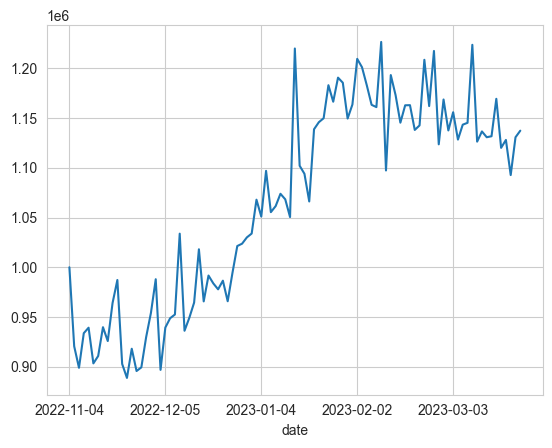

In [185]:
equity.plot()

In [188]:
print(f"annualized average return = {252*ret.mean(): .1%}")
print(f"annualized std dev is {np.sqrt(252)*ret.std(): .1%}")
print(f"annualized Sharpe ratio is {np.sqrt(252)*ret.mean()/ret.std(): .1%}")

annualized average return =  57.14%
annualized std dev is  67.57%
annualized Sharpe ratio is  84.57%


### Get industries

In [ ]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database 

conn = create_engine(string).connect()

In [139]:
portfolio = pd.concat((portfolio, cash), axis=1)
portfolio.columns = ["stocks", "cash"]
portfolio["total"] = portfolio.stocks + portfolio.cash

C:\Users\kerry\AppData\Local\Temp\ipykernel_24176\1912302579.py:1: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [140]:
portfolio.total

c:\Users\kerry\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\utils\dir2.py:65: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



date
2022-11-01                       NaN
2022-11-02                       NaN
2022-11-03                       NaN
2022-11-04                       NaN
2022-11-07             987763.891775
                           ...      
2023-03-09 00:00:00              NaN
2023-03-10 10:53:00              NaN
2023-03-16 00:00:00              NaN
2023-03-17 00:00:00              NaN
2023-03-21 00:00:00              NaN
Name: total, Length: 215, dtype: float64

In [126]:

price["position"] = trades.groupby("ticker").cumsum()

In [134]:
price["position"] = price.groupby("ticker").position.ffill()

In [39]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'

string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database 
conn = create_engine(string).connect()

In [44]:
df = pd.read_csv("C:/users/kerry/Dropbox/sep.csv")

In [41]:
df = pd.read_sql("select * from sep", conn)

In [46]:
df2 = df[df.ticker.isin(ticks)]

[*********************100%***********************]  96 of 96 completed

2 Failed downloads:
- FFHL: No timezone found, symbol may be delisted
- SPNE: No timezone found, symbol may be delisted


In [45]:
len(ticks)

96

In [51]:
lst = list(df2.ticker.unique())
[x for x in ticks if not x in lst]

['FFHL']

In [26]:
daily = pd.read_sql(" select a.ticker, date, close_ as price, closeadj, famaindustry as industry " 
                    " from sep a inner join tickers b on a.ticker=b.ticker " 
                    " where date>='2022-11-01' "
                    " order by ticker, date ", conn)
daily['date'] = pd.to_datetime(daily.date)
daily["ret"] = daily.groupby("ticker").closeadj.pct_change()
daily.head()

,ticker,date,price,closeadj,industry,ret
0,A,2022-11-01,140.89,140.678,Measuring and Control Equipment,NaN
1,A,2022-11-02,135.27,135.067,Measuring and Control Equipment,-0.039885
2,A,2022-11-03,134.46,134.258,Measuring and Control Equipment,-0.005990
3,A,2022-11-04,136.08,135.876,Measuring and Control Equipment,0.012051
4,A,2022-11-07,138.03,137.823,Measuring and Control Equipment,0.014329


In [25]:



history = daily.merge(trades,on=['ticker','date'],how='left')
history['trade'] = history.trade.fillna(0)
history['quantity'] = history.groupby('ticker').trade.cumsum()
history['value'] = history.price*history.quantity
history['sign'] = history.groupby('ticker').quantity.apply(np.sign)
history['lagsign'] = history.groupby('ticker').sign.shift()
history['gain'] = history.groupby('ticker', group_keys=False).apply(lambda d: d.value.shift()*d.ret)




C:\Users\kerry\AppData\Local\Temp\ipykernel_24176\2276736759.py:12: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [28]:
h = history.groupby(["date", "sign"]).value.sum().reset_index()
h = h [h.sign != 0]
h

,date,sign,value
3,2022-11-04,-1.0,-225174.450
5,2022-11-04,1.0,622159.445
6,2022-11-07,-1.0,-226875.730
8,2022-11-07,1.0,632398.985
9,2022-11-08,-1.0,-229829.340
...,...,...,...
278,2023-03-20,1.0,637217.010
279,2023-03-21,-1.0,-275226.000
281,2023-03-21,1.0,645489.890
282,2023-03-22,-1.0,-270548.780


In [17]:
import yfinance as yf
russell = yf.download("IWM", start="2022-11-01")["Adj Close"]
russell = russell/russell.iloc[0] - 1


[*********************100%***********************]  1 of 1 completed


In [18]:
# gains on longs and shorts and on Russell 2000 for all trading days



gains = history.groupby(['date','lagsign']).gain.sum().unstack()
gains = gains.drop(columns=0)
gains = gains.rename(columns={-1:'short',1:'long'})
gains = gains.cumsum()
gains['russell'] = 1000000 * russell

# portfolio value including cash

portfolio = history.groupby(['date','sign']).value.sum().unstack()
portfolio = portfolio.join(cash).drop(columns=0).dropna(how='all')
portfolio['cash'] = portfolio.cash.ffill()
portfolio = portfolio.rename(columns={-1:'short',1:'long'})
portfolio['total'] = portfolio.sum(axis=1)

# industry gains

industries = history.groupby(['industry','lagsign']).gain.sum().unstack().drop(columns=0)
industries = industries.rename(columns={-1:'short',1:'long'})

C:\Users\kerry\AppData\Local\Temp\ipykernel_24176\850946013.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['cash'] = portfolio.cash.ffill()


In [23]:
gains

lagsign,short,long,russell
date,,,
2022-11-02,NaN,NaN,NaN
2022-11-03,NaN,NaN,NaN
2022-11-04,NaN,NaN,NaN
2022-11-07,-1701.444814,10242.513462,NaN
2022-11-08,-4655.233338,18906.678145,NaN
...,...,...,...
2023-03-16,-5364.958073,16900.936119,NaN
2023-03-17,-2408.438073,3554.891646,NaN
2023-03-20,-3929.108073,8868.226322,NaN


# Create animation of industry weights

In [19]:
# calculate industry weights

hist = history.groupby(['industry','date']).value.sum()
inds = hist[hist!=0].index.unique('industry')
dates = hist.index.unique('date')
indx = pd.MultiIndex.from_product((inds,dates))
hist = hist.reindex(indx).fillna(0)
hist = hist.reset_index()
hist = hist.merge(portfolio.total,on='date',how='left')
mindate = hist[hist.total.notnull()].date.min()
hist = hist[hist.date>='2021-11-06']
hist['percent'] = hist.value/hist.total
hist = hist[['industry','date','percent']]
hist['date'] = hist.date.astype(str)

# sort industries by weights on start date

start = hist[hist.date=='2021-11-08']
ranks = start.sort_values(by='percent',ascending=False).industry.to_frame()
ranks['rnk'] = range(len(ranks))
ranks = ranks.set_index('industry')['rnk'].to_dict()
hist['rnk'] = hist.industry.map(ranks)
hist = hist.sort_values(by=['date','rnk'],ascending=(True,False))

# create animation - change size with height= and width= in px.bar()
import plotly.express as px
fig = px.bar(hist,y='industry',x='percent',animation_frame='date',orientation='h',height=600,width=800)
fig.layout.xaxis['title'] = 'Fraction of Portfolio Value'
fig.layout.yaxis['title'] = 'Industry'
fig.update_layout(margin=dict(l=30, r=20, t=20, b=200),paper_bgcolor="LightSteelBlue")
fig['layout'].pop('updatemenus')
fig.update_xaxes(title_font_size=16,range=[-0.60,0.20])
fig.update_yaxes(title_font_size=16)
fig.update_layout(font_size=14)
fig.write_html('industries.html')

# Risk analysis re Russell 2000

In [22]:
# compute returns
ret = portfolio.total.pct_change()
russ = russell.pct_change()
russ.index = pd.to_datetime(russ.index.astype(str))
rets = pd.concat((ret,russ),axis=1).dropna()
rets.columns=['RiceOwls','Russell2000']

# run regression
import statsmodels.api as sm
result = sm.OLS(rets.RiceOwls,sm.add_constant(rets.Russell2000)).fit()

# output results (all numbers in annualized percents, except beta)
alpha = 100*252*result.params['const']
beta = result.params['Russell2000']
activeRisk = 100*np.sqrt(252*result.mse_resid)
infoRatio =100*alpha / activeRisk
output = pd.Series([beta,alpha,activeRisk,infoRatio],index=['beta','alpha','active risk','info ratio'])
output.round(2)

ValueError: zero-size array to reduction operation maximum which has no identity

# Risk analysis re Fama-French and other factors

In [34]:
# combine returns with factors
ff = pdr('F-F_Research_Data_5_Factors_2x3_daily','famafrench')[0]/100
d1 = pdr('F-F_Momentum_Factor_daily','famafrench')[0]/100
d2 = pdr('F-F_ST_Reversal_Factor_daily','famafrench')[0]/100
d3 = pdr('F-F_LT_Reversal_Factor_daily','famafrench')[0]/100
data = pd.concat((ret,ff,d1,d2,d3),axis=1).dropna()
data = data.rename(columns={'total':'RiceOwls'})
data.columns = [x.strip() for x in data.columns]
data['RiceOwls'] = data.RiceOwls - data.RF
factors = ['Mkt-RF','SMB','HML','RMW','CMA','Mom','ST_Rev','LT_Rev']

# run regression
result = sm.OLS(data.RiceOwls,sm.add_constant(data[factors])).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0037,0.001,2.511,0.015,0.001,0.007
Mkt-RF,-0.0985,0.159,-0.621,0.538,-0.417,0.220
SMB,0.1878,0.227,0.828,0.412,-0.268,0.644
HML,-0.5695,0.375,-1.517,0.136,-1.323,0.184
RMW,1.7589,0.315,5.589,0.000,1.127,2.391
CMA,-1.1405,0.427,-2.670,0.010,-1.998,-0.283
Mom,0.8482,0.189,4.477,0.000,0.468,1.229
ST_Rev,0.0994,0.157,0.633,0.530,-0.216,0.415
LT_Rev,1.7393,0.513,3.389,0.001,0.708,2.770


In [35]:
# report important statistics (in annualized %)
alpha = 100*252*result.params['const']
activeRisk = 100*np.sqrt(252*result.mse_resid)
infoRatio = 100*alpha/activeRisk
output = pd.Series([alpha,activeRisk,infoRatio],index=['alpha','active risk','info ratio'])
output.round(2)

alpha           93.95
active risk     14.87
info ratio     631.76
dtype: float64

In [9]:
x = ['a','b','c']
x.remove('b')
x

['a', 'c']

In [ ]:
"""    
                raw_cum,
                columns=2
                )]
            ),
            dp.Page(
                title="Beta-adjusted benchmark",
                blocks=[dp.Group(
                    dp.Group(
                          dp.Text(
                    f"""
                    On this page, the active return is defined to be the return in excess of a beta-adjusted
                    benchmark return.  The beta-adjusted benchmark is a portfolio with a weight of 
                    beta on the benchmark
                    and one minus beta on the risk-free asset.  With this definition, the active return is
                    the intercept (alpha) in the regression plus the residual risk.  The mean active return
                    is the alpha, the tracking error is the standard deviation of the active return, and the
                    information ratio is the ratio of the alpha to the tracking error.    The alpha and its 
                    standard error
                    are in basis points per month.  The information ratio is in percent
                    per month.  In the regression, the dependent variable is the excess return over the risk-free
                    rate, and the independent variable is the excess return of the benchmark over the risk-free
                    rate.  The regression R-squared is {capm_r2:.1%}."""),
                            capm_tbl),
                    capm_reg, columns=2
                ),
                    dp.Text("""These figures show the sources of return.  The benchmark source is
                            the return of the beta-adjusted benchmark.  The active source
                            is the remaining part of the excess return (alpha plus residual risk).
                            """),
                    dp.Group(capm_box, capm_cum, columns=2)
                        ]
            ),
            dp.Page(
                title="Multi-factor analysis",
                blocks=[dp.Group(
                    dp.Group(
                        dp.Text(
                            f"""
                    On this page, a beta-adjusted benchmark is computed using a multiple regression
                    beta.  To compute the active return, we start with the return minus the beta-adjusted
                    benchmark return.  We then adjust for other known sources of return (factors) by 
                    subtracting the beta for the factor multiplied by the factor.  The remaining return is
                    the active return, and it equals the intercept (alpha) plus the residual risk in the
                    regression.  The mean active return is the alpha, the standard deviation of the active
                    return is a tracking error, and the ratio of the alpha to the tracking error is an
                    information ratio.  The alpha and its standard error
                    are in basis points per month.  The information ratio is in percent
                    per month.  In the regression, the dependent variable is the return minus the 
                    risk-free rate, and the independent variables are the factors and the benchmark return minus
                    the risk-free rate.  The regression R-squared is {ff_r2:.1%}."""
                                ),
                        ff_tbl),
                    dp.Group(
                        dp.Text("""The figures show the sources of returns.  The benchmark source is the
                    beta-adjusted benchmark return.  The factor sources are betas times
                        factor returns.  The active return is the remaining part of the excess return
                        (alpha plus residual risk).  The factors are size (SMB), value (HML), 
                        profitability (RMW), investment (CMA), momentum (Mom), short-term 
                        reversal (ST_Rev), 
                        and long-term reversal (LT_Rev).  To improve the scale, the beta-adjusted benchmark
                        return is not shown on the compound return plot. """),
                        ff_cum),
                        columns=2
                ),
                    dp.Group(ff_box)
                ]
            ),
            dp.Page(title='Data', blocks=[df])
        )

        fn = 'attribution.html'
        report.save('./tmp/' + fn)

        return fn
        """


In [8]:
['a','b','c'].replace('a','d')

AttributeError: 'list' object has no attribute 'replace'

In [6]:
import pandas as pd
d = pd.read_csv("C:\\Users\\kerry\\Downloads\\test.csv")
d['date'] = ['Feb 1, 2020', 'Mar 1, 2020', 'Apr 1, 2020', 'May 1, 2020']
d.to_csv("test.csv", index=False)

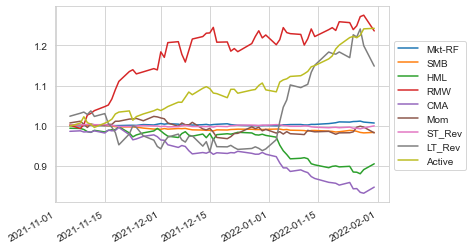

In [36]:
contribs = pd.DataFrame(dtype=float,index=data.index,columns=factors+['Active'])
for col in contribs.columns[:-1] :
    contribs[col] = data[col]*result.params[col]
contribs['Active'] = data.RiceOwls - contribs[factors].sum(axis=1)
(1+contribs).cumprod().plot()
lgnd = plt.legend(bbox_to_anchor=(1,0.85))
plt.savefig('attribution.pdf',bbox_extra_artists=(lgnd,),bbox_inches='tight')

# Dollar gains/losses by industry

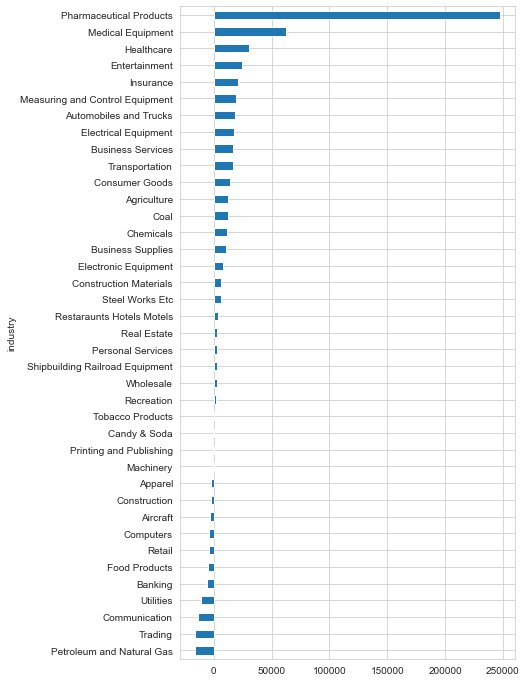

In [37]:
industries.dropna(how='all').sum(axis=1).sort_values().plot(kind='barh',figsize=(6,12))
plt.savefig('industries.pdf')